nuria -- up to 13.17 Hz decrease in rate
lo_qui_don -- up to 12.73 Hz decrease in rate


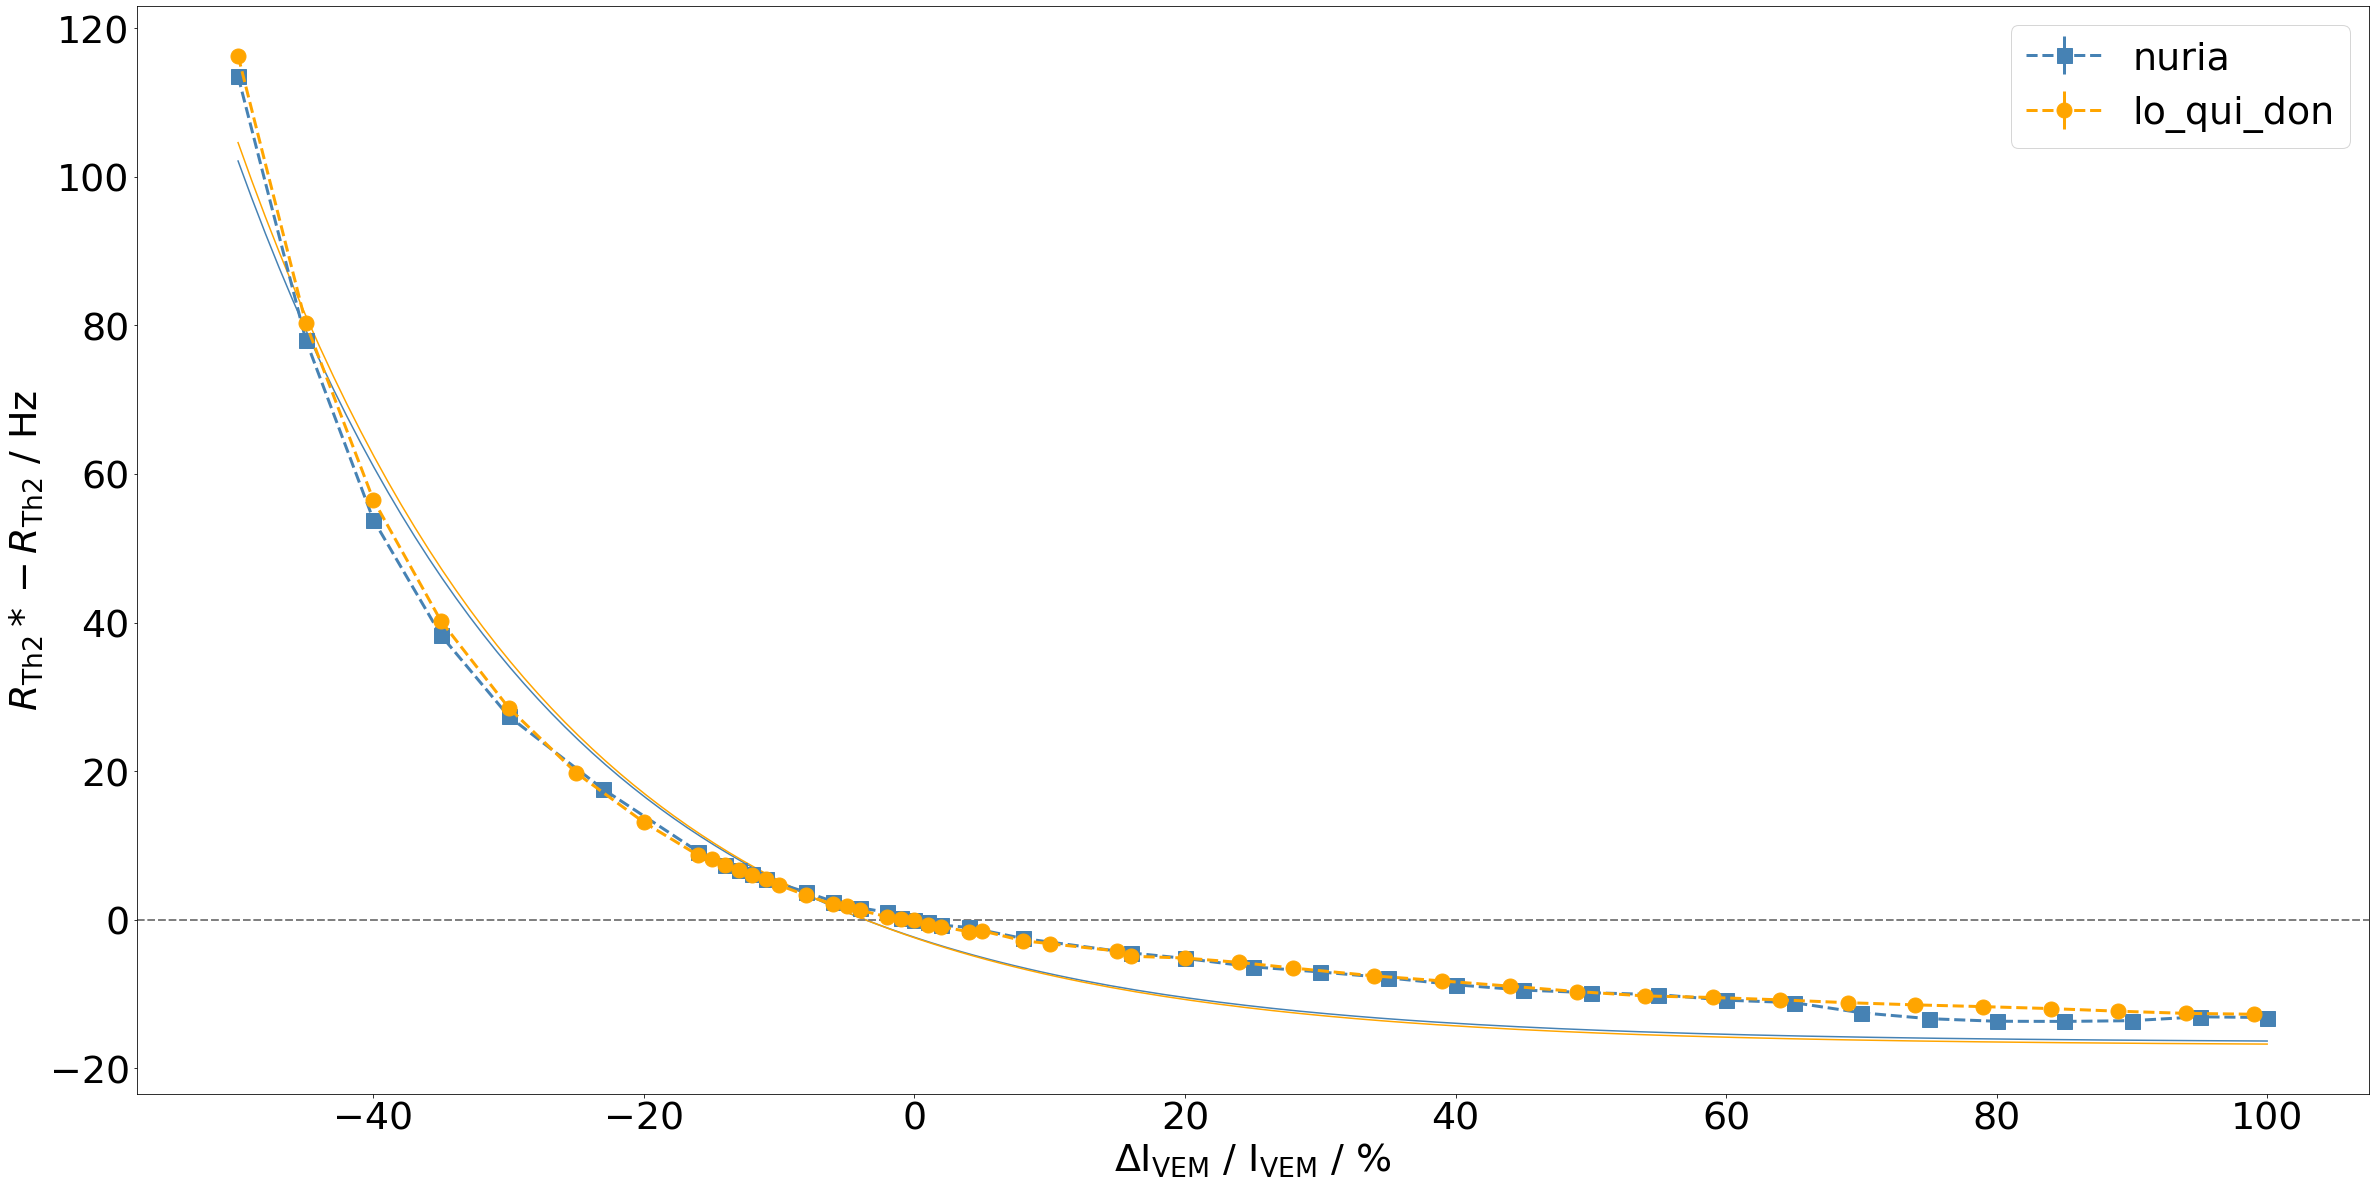

In [1]:
from Binaries import *
from scipy.optimize import curve_fit

def neg_exponential(x, a, b):
    return a * np.exp(- b * x)

plt.rcParams["figure.figsize"] = [40, 20]
plt.rcParams["font.size"] = 38


def neg_exponential(x, a, b):
    return a * np.exp(- b * x)

stations = \
    {
        "nuria" : 56,
        "lo_qui_don" : 1744,
    }

for i_station, directory in enumerate(os.listdir("./trigger_output")):

    # if directory == "lo_qui_don": continue
    
    r_th2, r_tot = [], []
    e_th2, e_tot = [], []
    x, r_total = [], []
    e_total = []
    x_online = []

    for file in os.listdir(f"./trigger_output/{directory}/"):


        if file == "trace_increment": continue

        t, th2, tot, tod = np.loadtxt("/cr/users/filip/Trigger/RunProductionTest/trigger_output/" + directory + "/" + file, unpack = True, usecols = [2,4,5,6])

        p = file.split("_")[-1][:-4]

        try:
            x.append(float(p[1:]) if p[0] == "p" else -1 * float(p[1:]))
        except ValueError: x.append(0)

        duration = t.sum()
        rate_th2 = th2.sum() / duration
        rate_tot = tot.sum() / duration
        rate_tod = tod.sum() / duration
        error_th2 = np.std(th2)
        error_tot = np.std(tot)
        error_tod = np.std(tod)

        r_th2.append(rate_th2)
        r_tot.append(rate_tot + rate_tod)

        rate_total = rate_th2 + rate_tot + rate_tod
        error_total = np.sqrt(error_th2**2 + error_tot**2 + error_tod**2)
        r_total.append(rate_total)
        
        e_th2.append(error_th2 / duration)
        e_tot.append(np.sqrt(error_tot**2 + error_tod**2) / duration)
        e_total.append(error_total / duration)

    ii = np.argsort(x)
    x = np.array(x)[ii]
    r_total = np.array(r_total)[ii]
    r_th2 = np.array(r_th2)[ii]
    r_tot = np.array(r_tot)[ii]

    X = np.linspace(-50, 100, 150)
    # popt_total, pcov = curve_fit(neg_exponential, x, r_total, bounds = (0, np.inf), p0 = [r_total[11], 1])
    # plt.plot(X, neg_exponential(X, *popt_tot))
    popt_th2, pcov = curve_fit(neg_exponential, x, r_th2, bounds = (0, np.inf), p0 = [r_th2[11], 1])
    plt.plot(X, neg_exponential(X, *popt_th2) - r_th2[np.argmin(abs(x))], c = "steelblue" if i_station == 0 else "orange")
    # popt_tot, pcov = curve_fit(neg_exponential, x, r_tot, bounds = (0, np.inf), p0 = [r_tot[11], 1])
    # plt.plot(X, neg_exponential(X, *popt_tot))

    plt.errorbar(x, r_th2 - r_th2[np.argmin(abs(x))], yerr = e_th2, fmt = "--s" if i_station == 0 else "--o" , label = directory, markersize = 15, c = "steelblue" if i_station == 0 else "orange", lw = 3)

    plt.axhline(0, c = "gray", ls = "--", lw = 2)
    plt.xlabel(r"$\Delta$I$_\mathrm{VEM}$ / I$_\mathrm{VEM}$ / %")
    plt.ylabel(r"$R_\mathrm{Th2}* - R_\mathrm{Th2}$ / Hz")
    plt.legend()

    print(f"{directory} -- up to {r_th2[np.argmin(abs(x))] - r_th2[-1]:.2f} Hz decrease in rate")